# Visualization of generated Data

In [1]:
import matplotlib.pyplot as plt
%matplotlib widget


In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt


# load data
path = './OOP_data_cube.csv'
df = pd.read_csv(path)

# Balance the data to make sure the classes are equally represented

# Separate majority and minority classes
majority = df[df['result'] == 0]
minority = df[df['result'] == 1]

# Over-sample minority class
minority_oversampled = resample(minority, 
                                replace=True,     # Sample with replacement
                                n_samples=len(majority),  # Match majority class count
                                random_state=42)  # Reproducibility

# Combine majority class with upsampled minority class
balanced_df = pd.concat([majority, minority_oversampled])

# Shuffle the dataset (optional, but recommended)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert it to numpy
X = balanced_df[["x","y","z","x_ori","y_ori","z_ori"]].to_numpy()
Y = balanced_df["result"].to_numpy()
print(X.shape)
print(Y.shape)

%matplotlib widget

(7590, 6)
(7590,)


### Plot the Orientation of the arm as a little arrow


In [2]:
from mpl_toolkits.mplot3d import Axes3D

def euler_to_vector(roll, pitch, yaw):
    """Convert Euler angles to direction vector"""
    # Assuming angles are in radians. If in degrees, convert using np.deg2rad()
    
    # First, create rotation matrices
    # Roll (rotation around x-axis)
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(roll), -np.sin(roll)],
                   [0, np.sin(roll), np.cos(roll)]])
    
    # Pitch (rotation around y-axis)
    Ry = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                   [0, 1, 0],
                   [-np.sin(pitch), 0, np.cos(pitch)]])
    
    # Yaw (rotation around z-axis)
    Rz = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                   [np.sin(yaw), np.cos(yaw), 0],
                   [0, 0, 1]])
    
    # Combine rotations
    R = Rz @ Ry @ Rx
    
    # Apply rotation to unit vector [1,0,0] to get direction
    direction = R @ np.array([1, 0, 0])
    
    return direction


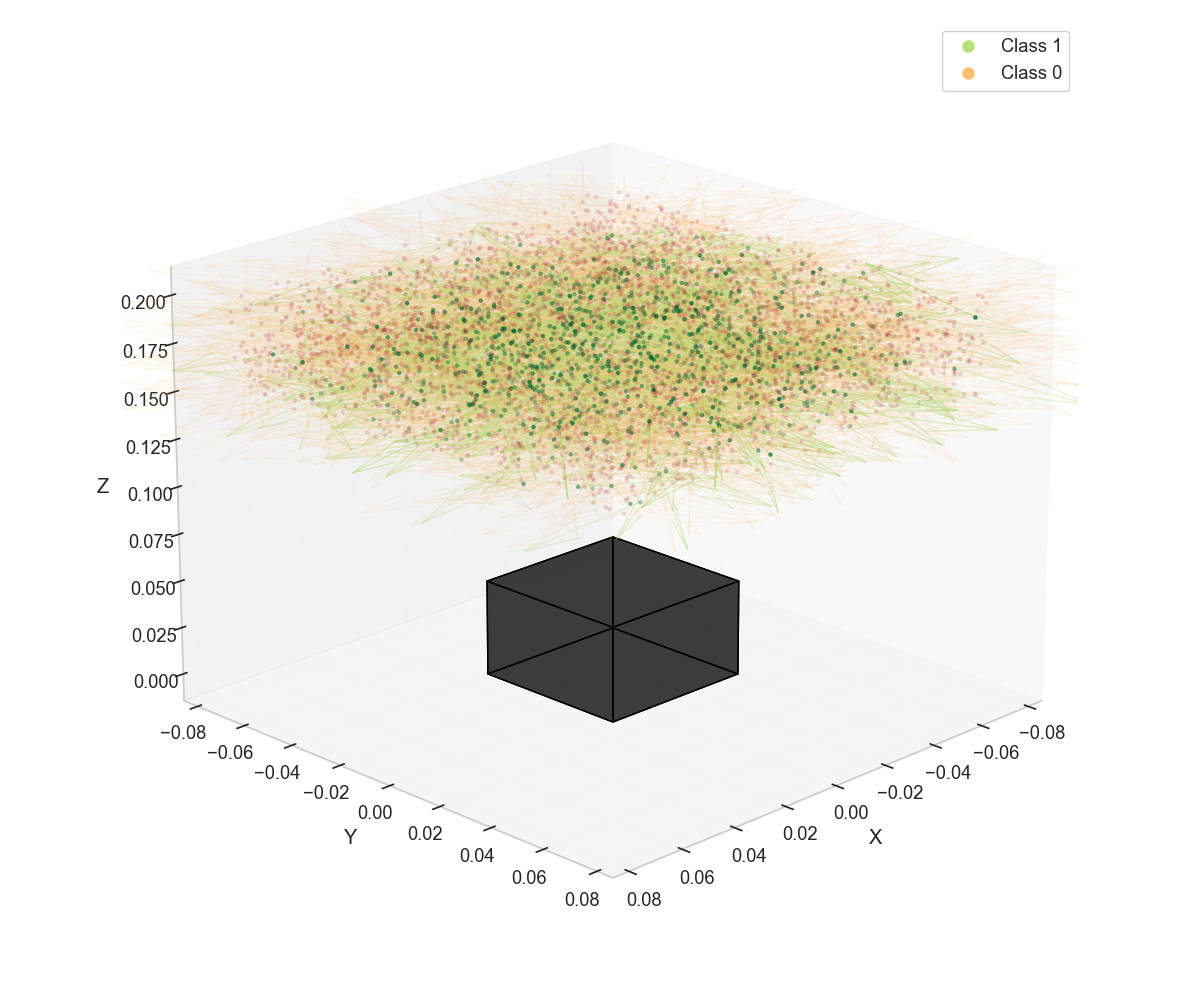

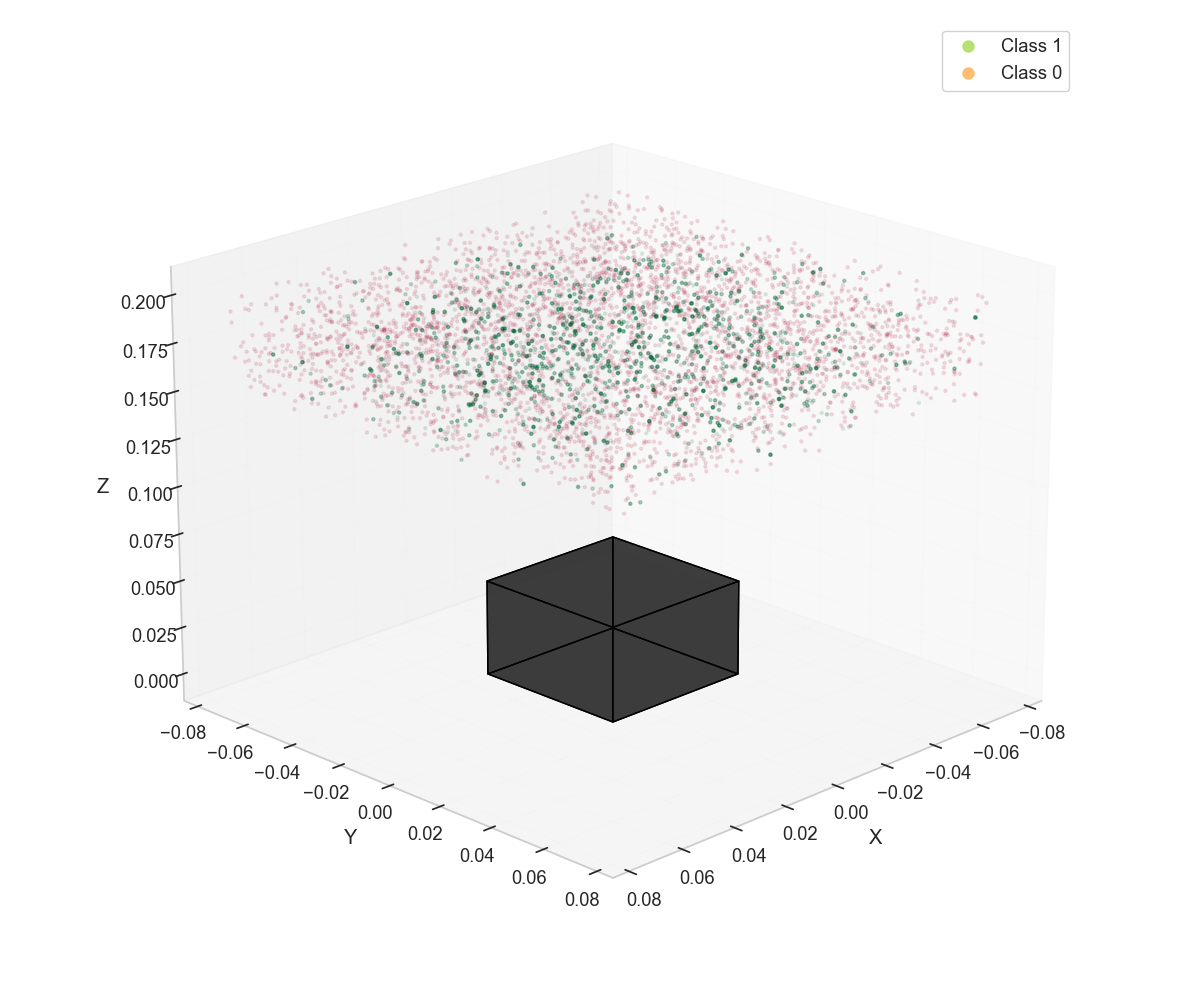

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_orientations(X, Y, euler_to_vector, show_arrows=True, arrow_length=0.04, 
                        point_size=5, alpha=0.1, center_point_size=100):
    """
    Create a 3D scatter plot with optional orientation arrows using seaborn styling.
    
    Parameters:
    X : numpy array of shape (N, 6) containing positions and orientations
    Y : numpy array of shape (N,) containing binary labels
    euler_to_vector : function to convert euler angles to direction vectors
    show_arrows : boolean, whether to show orientation arrows
    arrow_length : float, length of orientation arrows
    point_size : int, size of scatter points
    alpha : float, transparency of points and arrows
    center_point_size : int, size of center reference point
    """
    # Set seaborn style
    sns.set_style("whitegrid", {'grid.linestyle': '--'})
    sns.set_context("notebook", font_scale=1.2)
    
    # Create custom color palette
    colors = sns.color_palette("RdYlGn", n_colors=2)
    
    # Create figure and 3D axes
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Split the coordinates and orientations
    N = len(Y)
    positions = X[:N, :3]
    orientations = X[:N, 3:]
    
    # Create scatter plot with seaborn color palette
    scatter = ax.scatter(positions[:, 0],
                        positions[:, 1],
                        positions[:, 2],
                        c=Y,
                        cmap=sns.color_palette("RdYlGn", as_cmap=True),
                        marker='o',
                        s=point_size,
                        alpha=alpha)
    
    # Add orientation arrows if requested
    if show_arrows:
        for pos, ori, label in zip(positions, orientations, Y):
            color = colors[1] if label == 1 else colors[0]
            direction = euler_to_vector(*ori)
            ax.quiver(pos[0], pos[1], pos[2],
                     direction[0] * arrow_length,
                     direction[1] * arrow_length,
                     direction[2] * arrow_length,
                     color=color,
                     arrow_length_ratio=0.5,
                     linewidth=0.8,
                     alpha=alpha)
    
    # # Add center reference point
    # ax.scatter(0, 0, 0, color='black', s=center_point_size, alpha=0.5, marker='o')
    
    
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection

    # Add center reference cube
    cube_length = 0.05
    cube_vertices = np.array([
        [-cube_length/2, -cube_length/2, 0],
        [-cube_length/2, -cube_length/2,  cube_length],
        [-cube_length/2,  cube_length/2, 0],
        [-cube_length/2,  cube_length/2,  cube_length],
        [ cube_length/2, -cube_length/2, 0],
        [ cube_length/2, -cube_length/2,  cube_length],
        [ cube_length/2,  cube_length/2, 0],
        [ cube_length/2,  cube_length/2,  cube_length]
    ])

    # Faces of the cube
    cube_faces = [
        [cube_vertices[0], cube_vertices[1], cube_vertices[3], cube_vertices[2]],  # -X face
        [cube_vertices[4], cube_vertices[5], cube_vertices[7], cube_vertices[6]],  # +X face
        [cube_vertices[0], cube_vertices[1], cube_vertices[5], cube_vertices[4]],  # -Y face
        [cube_vertices[2], cube_vertices[3], cube_vertices[7], cube_vertices[6]],  # +Y face
        [cube_vertices[0], cube_vertices[2], cube_vertices[6], cube_vertices[4]],  # -Z face
        [cube_vertices[1], cube_vertices[3], cube_vertices[7], cube_vertices[5]],  # +Z face
    ]

    # Add cube to the plot
    ax.add_collection3d(Poly3DCollection(cube_faces, color='black', alpha=0.5))

    
    
    
    
    # Customize axes
    ax.set_xlabel('X', labelpad=10)
    ax.set_ylabel('Y', labelpad=10)
    ax.set_zlabel('Z', labelpad=10)
    
    # Add legend with seaborn styling
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w',
                  markerfacecolor=colors[1], label='Class 1',
                  markersize=10),
        plt.Line2D([0], [0], marker='o', color='w',
                  markerfacecolor=colors[0], label='Class 0',
                  markersize=10)
    ]
    ax.legend(handles=legend_elements, loc='upper right',
             frameon=True, facecolor='white', framealpha=0.9)
    
    # Set viewing angle
    ax.view_init(elev=20, azim=45)
    
    # Adjust layout and style
    plt.tight_layout()
    
    # Remove grid lines from the back of the plot
    ax.xaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.1)
    ax.yaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.1)
    ax.zaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.1)
    
    return fig, ax




# plot_3d_orientations(X, Y)
# plt.show()


plot_3d_orientations(X, Y, euler_to_vector)
plt.show()

plot_3d_orientations(X, Y, euler_to_vector, show_arrows=False)
plt.show()

In [14]:
feature_names = [f'X{i+1}' for i in range(X.shape[1])]
print(len(feature_names))

6


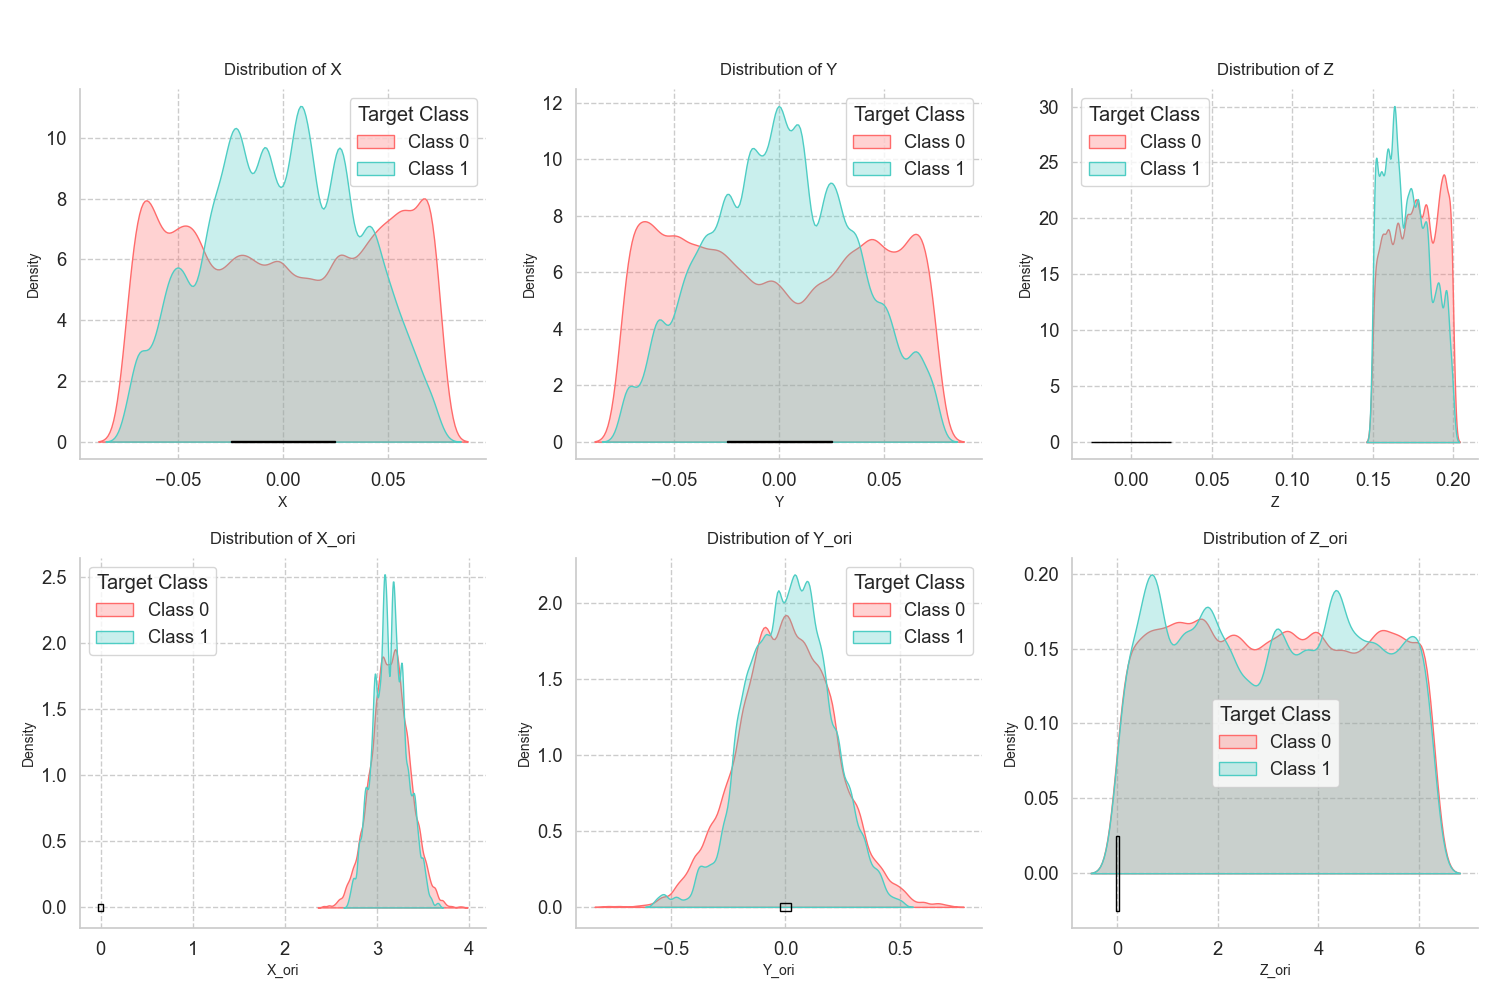

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_feature_distributions(X, y, feature_names=None, bw_adjust=0.5, n_points=200):
    """
    Create smooth distribution plots for features split by target class.
    
    Parameters:
    X : array-like of shape (n_samples, n_features)
        Feature matrix
    y : array-like of shape (n_samples,)
        Binary target variable (0 or 1)
    feature_names : list of str, optional
        Names of the features. If None, will use X1, X2, etc.
    bw_adjust : float, optional (default=0.5)
        Bandwidth adjustment factor for kernel density estimation
    n_points : int, optional (default=200)
        Number of points to evaluate the density on
    """
    # Convert inputs to numpy arrays
    X = np.asarray(X)
    y = np.asarray(y)
    
    # Input validation
    if X.ndim != 2:
        raise ValueError("X must be a 2D array")
    if y.ndim != 1:
        raise ValueError("y must be a 1D array")
    if X.shape[0] != y.shape[0]:
        raise ValueError("X and y must have the same number of samples")
    
    # Generate feature names if not provided
    if feature_names is None:
        feature_names = [f'X{i+1}' for i in range(X.shape[1])]
    elif len(feature_names) != X.shape[1]:
        raise ValueError("Number of feature names must match number of features")
    
    # Create DataFrame for seaborn
    X_df = pd.DataFrame(X, columns=feature_names)
    
    # Create figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Feature Distributions by Target Class', fontsize=16, y=1.02)
    
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['axes.titlepad'] = 10
    
    # Color palette
    colors = ['#FF6B6B', '#4ECDC4']
    
    # Plot distributions for each feature
    for idx, (col_name, ax) in enumerate(zip(feature_names, axes.ravel())):
        # Get feature data
        feature_data = X_df[col_name]
        
        # Calculate bounds for smooth interpolation
        x_min = feature_data.min() - 0.1 * (feature_data.max() - feature_data.min())
        x_max = feature_data.max() + 0.1 * (feature_data.max() - feature_data.min())
        x_grid = np.linspace(x_min, x_max, n_points)
        
        # Plot distributions with increased smoothing
        sns.kdeplot(data=feature_data[y == 0], 
                   ax=ax, 
                   color=colors[0], 
                   label='Class 0',
                   bw_adjust=bw_adjust,
                   fill=True,
                   alpha=0.3)
        
        sns.kdeplot(data=feature_data[y == 1], 
                   ax=ax, 
                   color=colors[1], 
                   label='Class 1',
                   bw_adjust=bw_adjust,
                   fill=True,
                   alpha=0.3)
        
        # Customize plot
        ax.set_title(f'Distribution of {col_name}', fontsize=12)
        ax.set_xlabel(col_name, fontsize=10)
        ax.set_ylabel('Density', fontsize=10)
        ax.legend(title='Target Class')
        
        # Remove top and right spines
        sns.despine(ax=ax)
    
    # Adjust layout
    plt.tight_layout()
    return fig



feature_names = ['X', 'Y', 'Z', 'X_ori', 'Y_ori', 'Z_ori']
# Create the plots
plot_feature_distributions(X, Y, feature_names, bw_adjust=0.5, n_points=200)
plt.show()

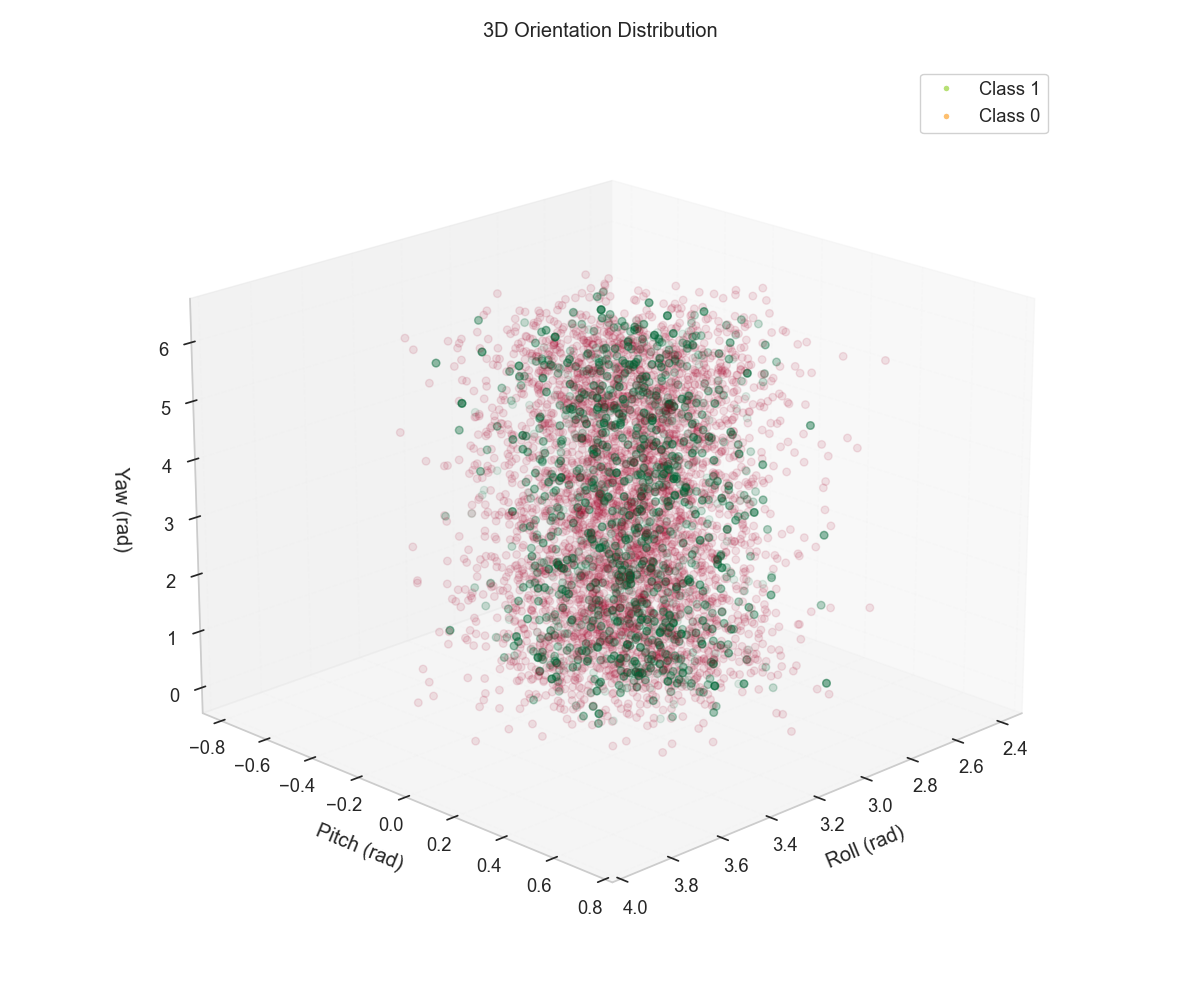

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def plot_orientations_3d(orientations, labels, point_size=30, alpha=0.1):
    """
    Create a 3D scatter plot of orientations with seaborn styling.
    
    Parameters:
    orientations : numpy array of shape (N, 3) containing euler angles
    labels : numpy array of shape (N,) containing binary labels
    point_size : int, size of scatter points
    alpha : float, transparency of points
    """
    # Set seaborn style
    sns.set_style("whitegrid", {'grid.linestyle': '--'})
    sns.set_context("notebook", font_scale=1.2)
    
    # Create custom color palette
    colors = sns.color_palette("RdYlGn", n_colors=2)
    
    # Create figure and 3D axes
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create scatter plot with seaborn color palette
    scatter = ax.scatter(orientations[:, 0],
                        orientations[:, 1],
                        orientations[:, 2],
                        c=labels,
                        cmap=sns.color_palette("RdYlGn", as_cmap=True),
                        marker='o',
                        s=point_size,
                        alpha=alpha)
    
    # Customize axes
    ax.set_xlabel('Roll (rad)', labelpad=10)
    ax.set_ylabel('Pitch (rad)', labelpad=10)
    ax.set_zlabel('Yaw (rad)', labelpad=10)
    
    # Add title
    plt.title('3D Orientation Distribution', pad=20)
    
    # Add legend with seaborn styling
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w',
                  markerfacecolor=colors[1], label='Class 1',
                  markersize=5, alpha=1),
        plt.Line2D([0], [0], marker='o', color='w',
                  markerfacecolor=colors[0], label='Class 0',
                  markersize=5, alpha=1)
    ]
    ax.legend(handles=legend_elements, loc='upper right',
             frameon=True, facecolor='white', framealpha=0.9)
    
    # Set viewing angle
    ax.view_init(elev=20, azim=45)
    
    # Adjust layout and style
    plt.tight_layout()
    
    # Remove grid lines from the back of the plot
    ax.xaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.1)
    ax.yaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.1)
    ax.zaxis._axinfo["grid"]['color'] = (0.9, 0.9, 0.9, 0.1)
    
    return fig, ax

# Example usage:
# Assuming X contains your data and Y contains labels
# orientations = X[:, 3:]  # Taking only the orientation part
# plot_orientations_3d(orientations, Y)
# plt.show()

# Example with random data:
np.random.seed(42)
n_samples = 1000
orientations = balanced_df[["x_ori","y_ori","z_ori"]].to_numpy()

fig, ax = plot_orientations_3d(orientations, Y)
plt.show()

# Classifier (Feedforward Neural Network)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class PointOrientationDataset(Dataset):
    """Custom Dataset for point cloud orientation data."""
    def __init__(self, X, y, transform=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        self.transform = transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        sample = self.X[idx], self.y[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

class BinaryClassifier(nn.Module):
    """Neural network for binary classification."""
    def __init__(self, input_size, hidden_sizes=[64, 32]):
        super(BinaryClassifier, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_size),
                nn.Dropout(0.2)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

def calculate_metrics(outputs, labels):
    """Calculate accuracy for a batch."""
    predictions = (outputs.squeeze() > 0.5).float()
    correct = (predictions == labels).float().sum()
    return correct.item() / len(labels)

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epoch):
    """Train the model for one epoch and validate."""
    model.train()
    running_loss = 0.0
    train_accuracy = 0.0
    
    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_accuracy += calculate_metrics(outputs, labels)
    
    avg_train_loss = running_loss / len(train_loader)
    avg_train_accuracy = train_accuracy / len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            val_loss += loss.item()
            val_accuracy += calculate_metrics(outputs, labels)
    
    avg_val_loss = val_loss / len(val_loader)
    avg_val_accuracy = val_accuracy / len(val_loader)
    
    return avg_train_loss, avg_train_accuracy, avg_val_loss, avg_val_accuracy

def evaluate_model(model, test_loader, device):
    """Evaluate the model and return predictions and true labels."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = (outputs.squeeze() > 0.5).float()
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training and validation metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix using seaborn."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def train_and_evaluate(X, Y, batch_size=32, epochs=20, learning_rate=0.001, 
                      hidden_sizes=[64, 32], train_split=0.7, val_split=0.15):
    """Complete training and evaluation pipeline with validation."""
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data into train, validation, and test sets
    X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, Y, 
                                                     test_size=1-train_split-val_split, 
                                                     random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                     test_size=val_split/(train_split+val_split),
                                                     random_state=42)
    
    # Create datasets and dataloaders
    train_dataset = PointOrientationDataset(X_train, y_train)
    val_dataset = PointOrientationDataset(X_val, y_val)
    test_dataset = PointOrientationDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize model, criterion, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BinaryClassifier(X.shape[1], hidden_sizes=hidden_sizes).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    print("Starting training...")
    for epoch in range(epochs):
        train_loss, train_acc, val_loss, val_acc = train_model(
            model, train_loader, val_loader, criterion, optimizer, device, epoch
        )
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
            print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')
    
    # Plot training metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
    
    # Final evaluation
    print("\nFinal Evaluation:")
    y_pred, y_true = evaluate_model(model, test_loader, device)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred)
    
    return model, (train_losses, val_losses, train_accuracies, val_accuracies), (y_pred, y_true)


if __name__ == "__main__":
    # Load and prepare data
    path = './bigger_better_cooler_data.csv'
    df = pd.read_csv(path)
    
    # Balance classes
    majority = df[df['result'] == 0]
    minority = df[df['result'] == 1]
    minority_oversampled = resample(minority, 
                                  replace=True,
                                  n_samples=len(majority),
                                  random_state=42)
    balanced_df = pd.concat([majority, minority_oversampled])
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Prepare features and labels
    X = balanced_df[["x","y","z","x_ori","y_ori","z_ori"]].to_numpy()
    Y = balanced_df["result"].to_numpy()
    
    # Train and evaluate the model with enhanced metrics
    model, metrics, (y_pred, y_true) = train_and_evaluate(
        X, Y,
        batch_size=32,
        epochs=20,
        learning_rate=0.001,
        hidden_sizes=[64, 32]
    )

ModuleNotFoundError: No module named 'torch'

## Classifier (SVM)


Testing kernel=rbf, C=0.1
Accuracy: 0.7609

Testing kernel=rbf, C=1.0
Accuracy: 0.8445

Testing kernel=rbf, C=10.0
Accuracy: 0.8880

Testing kernel=linear, C=0.1
Accuracy: 0.5593

Testing kernel=linear, C=1.0
Accuracy: 0.5599

Testing kernel=linear, C=10.0
Accuracy: 0.5593

Best parameters: {'kernel': 'rbf', 'C': 10.0}
Best accuracy: 0.8880
Training SVM model...
Making predictions...

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       779
           1       0.84      0.94      0.89       739

    accuracy                           0.89      1518
   macro avg       0.89      0.89      0.89      1518
weighted avg       0.89      0.89      0.89      1518



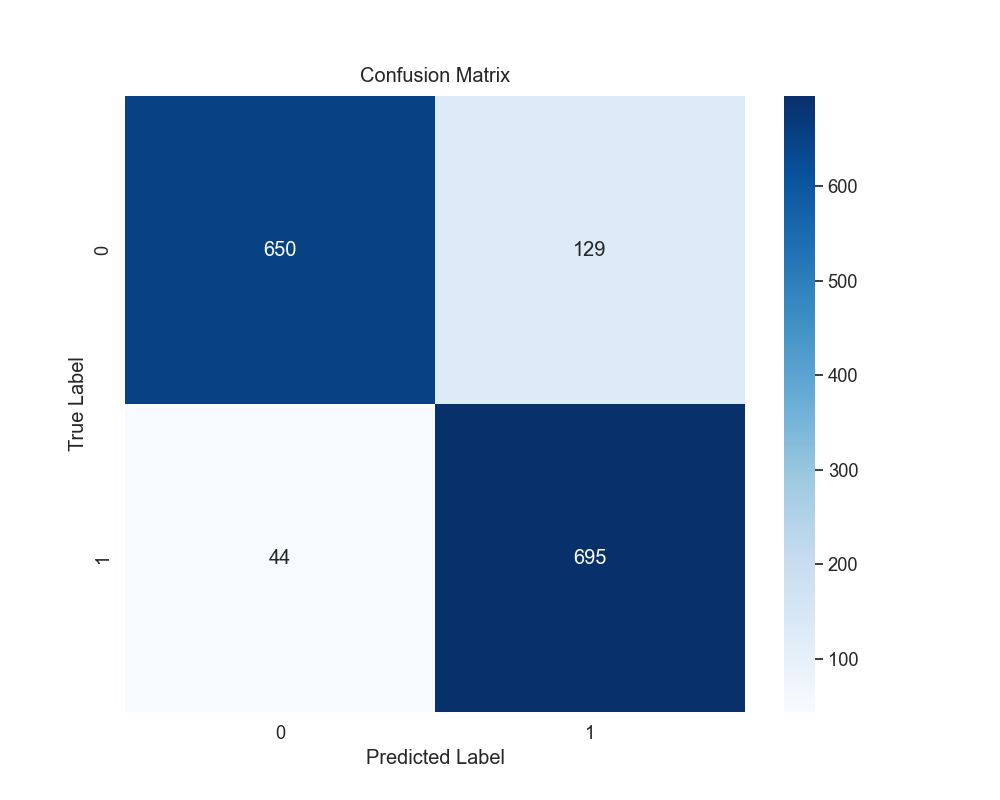

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

class SVMClassifier:
    """SVM Classifier wrapper to maintain compatibility with neural network interface."""
    def __init__(self, kernel='rbf', C=1.0):
        self.model = SVC(kernel=kernel, C=C, probability=True)
        self.device = 'cpu'  # For compatibility with neural network interface
    
    def to(self, device):
        """Mock method for compatibility."""
        return self
    
    def train(self):
        """Mock method for compatibility."""
        pass
    
    def eval(self):
        """Mock method for compatibility."""
        pass

def train_svm_model(X, Y, kernel='rbf', C=1.0, train_split=0.8):
    """
    Train and evaluate SVM model using the existing visualization pipeline.
    
    Parameters:
    -----------
    X : numpy array
        Input features
    Y : numpy array
        Target labels
    kernel : str
        SVM kernel type ('rbf', 'linear', 'poly', 'sigmoid')
    C : float
        Regularization parameter
    train_split : float
        Proportion of data to use for training
    """
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the data
    train_size = int(len(X_scaled) * train_split)
    indices = np.random.permutation(len(X_scaled))
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    X_train, X_test = X_scaled[train_indices], X_scaled[test_indices]
    y_train, y_test = Y[train_indices], Y[test_indices]
    
    # Initialize and train SVM
    print("Training SVM model...")
    svm_model = SVMClassifier(kernel=kernel, C=C)
    svm_model.model.fit(X_train, y_train)
    
    # Make predictions
    print("Making predictions...")
    y_pred = svm_model.model.predict(X_test)
    
    # Calculate and print classification report
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)
    
    # Plot confusion matrix using existing function
    plot_confusion_matrix(y_test, y_pred)
    
    return svm_model, (y_pred, y_test)

def parameter_search_svm(X, Y, train_split=0.8):
    """
    Perform a small parameter search for SVM hyperparameters.
    
    Parameters:
    -----------
    X : numpy array
        Input features
    Y : numpy array
        Target labels
    train_split : float
        Proportion of data to use for training
    """
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the data
    train_size = int(len(X_scaled) * train_split)
    indices = np.random.permutation(len(X_scaled))
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    X_train, X_test = X_scaled[train_indices], X_scaled[test_indices]
    y_train, y_test = Y[train_indices], Y[test_indices]
    
    # Parameter grid
    kernels = ['rbf', 'linear']
    C_values = [0.1, 1.0, 10.0]
    
    best_score = 0
    best_params = {}
    
    # Simple grid search
    for kernel in kernels:
        for C in C_values:
            print(f"\nTesting kernel={kernel}, C={C}")
            model = SVC(kernel=kernel, C=C)
            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            print(f"Accuracy: {score:.4f}")
            
            if score > best_score:
                best_score = score
                best_params = {'kernel': kernel, 'C': C}
    
    print(f"\nBest parameters: {best_params}")
    print(f"Best accuracy: {best_score:.4f}")
    
    return best_params


if __name__ == "__main__":
    # Load and prepare data
    path = './bigger_better_cooler_data.csv'
    df = pd.read_csv(path)
    
    # Balance classes
    majority = df[df['result'] == 0]
    minority = df[df['result'] == 1]
    minority_oversampled = resample(minority, 
                                  replace=True,
                                  n_samples=len(majority),
                                  random_state=42)
    balanced_df = pd.concat([majority, minority_oversampled])
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Prepare features and labels
    X = balanced_df[["x","y","z","x_ori","y_ori","z_ori"]].to_numpy()
    Y = balanced_df["result"].to_numpy()
    
    # Optional: Find best parameters first
    best_params = parameter_search_svm(X, Y)
    
    # Train and evaluate SVM with best parameters
    svm_model, (y_pred, y_true) = train_svm_model(
        X, Y,
        kernel=best_params['kernel'],
        C=best_params['C']
    )

## Feature Analysis

Performing t-SNE...


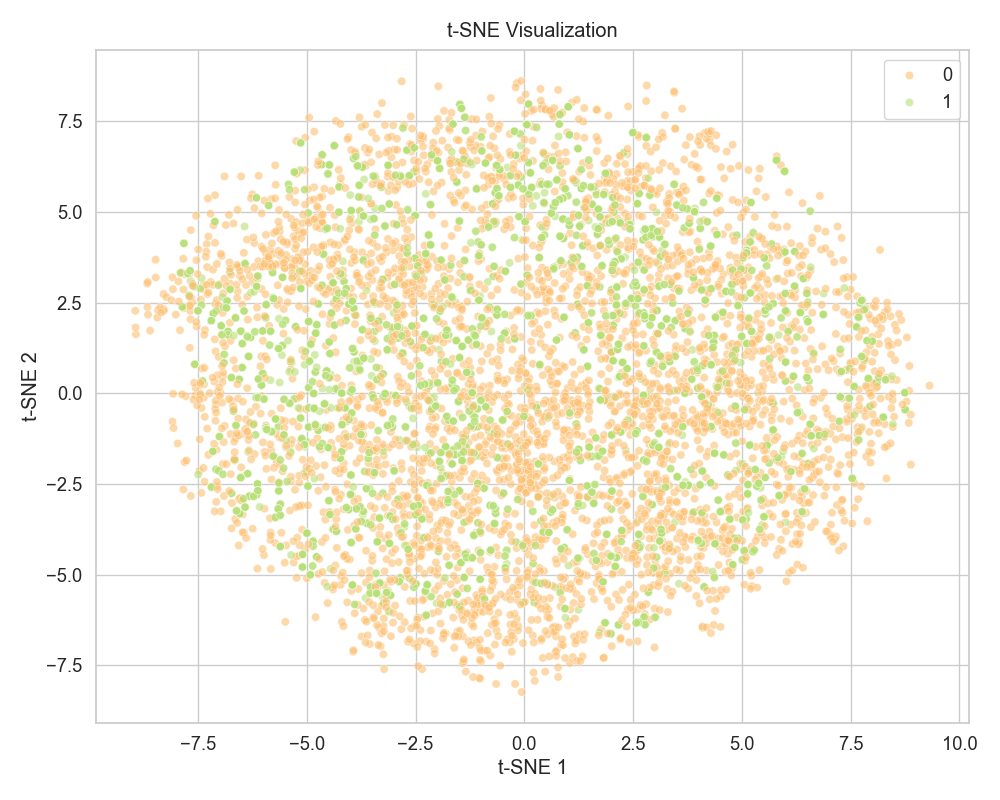

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

def visualize_tsne(X, y, perplexity=30, learning_rate=200):
    """
    Perform t-SNE and visualize results using seaborn.
    
    Parameters:
    -----------
    X : array-like
        Input features
    y : array-like
        Labels for coloring
    perplexity : float
        The perplexity parameter for t-SNE
    learning_rate : float
        The learning rate for t-SNE
    """
    # Scale the data
    X_scaled = StandardScaler().fit_transform(X)
    
    # Perform t-SNE
    print("Performing t-SNE...")
    tsne = TSNE(n_components=2, perplexity=perplexity, 
                learning_rate=learning_rate, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Set seaborn style
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 8))
    
    # Create scatter plot
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], 
                   hue=y, palette='RdYlGn', alpha=0.6)
    
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    
    plt.tight_layout()
    plt.show()
    
    return X_tsne

# Example usage
X_tsne = visualize_tsne(X, Y, perplexity=1000)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

def investigate_data_split_ratios_with_repeats(X, Y, ratios, nn_params, repeats=10):
    """
    Investigate the relationship between validation accuracy and data split ratio for SVM and NN,
    running each experiment multiple times and performing parameter search for SVM.
    
    Parameters:
    -----------
    X : numpy array
        Input features
    Y : numpy array
        Target labels
    ratios : list of floats
        Ratios of training to validation data.
    nn_params : dict
        Parameters for the neural network training function.
    repeats : int
        Number of times to repeat the experiment for each ratio.
    
    Returns:
    --------
    pd.DataFrame
        Results as a dataframe with columns: ['Ratio', 'Model', 'Accuracy']
    """
    results = []

    for ratio in ratios:
        print(f"\nProcessing ratio: {ratio:.2f} (train:validation = {ratio:.2f}:1)")
        train_split = ratio / (1 + ratio)
        val_split = 1 - train_split
        
        for repeat in range(1, repeats + 1):
            print(f"  Repetition {repeat}/{repeats}...")
            
            # Split data into train+validation and test sets
            X_trainval, X_test, y_trainval, y_test = train_test_split(
                X, Y, test_size=0.2, random_state=None
            )
            
            # Further split train+validation into training and validation sets
            X_train, X_val, y_train, y_val = train_test_split(
                X_trainval, y_trainval, test_size=val_split / (train_split + val_split), random_state=None
            )
            
            # Neural Network
            print(f"    Training NN for ratio {ratio:.2f}...")
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = BinaryClassifier(X.shape[1], hidden_sizes=nn_params['hidden_sizes']).to(device)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=nn_params['learning_rate'])
            
            train_dataset = PointOrientationDataset(X_train, y_train)
            val_dataset = PointOrientationDataset(X_val, y_val)
            
            train_loader = DataLoader(train_dataset, batch_size=nn_params['batch_size'], shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=nn_params['batch_size'])
            
            for epoch in range(nn_params['epochs']):
                train_loss, train_acc, val_loss, val_acc = train_model(
                    model, train_loader, val_loader, criterion, optimizer, device, epoch
                )
            
            print(f"    NN validation accuracy: {val_acc:.4f}")
            results.append({'Ratio': ratio, 'Model': 'NN', 'Accuracy': val_acc})
            
            # SVM with Parameter Search
            print(f"    Performing parameter search for SVM (ratio {ratio:.2f})...")
            best_params = parameter_search_svm(X_trainval, y_trainval, train_split=train_split)
            
            print(f"    Training SVM with best parameters: {best_params}...")
            svm_model = SVC(kernel=best_params['kernel'], C=best_params['C'])
            svm_model.fit(X_train, y_train)
            svm_accuracy = svm_model.score(X_val, y_val)
            print(f"    SVM validation accuracy: {svm_accuracy:.4f}")
            results.append({'Ratio': ratio, 'Model': 'SVM', 'Accuracy': svm_accuracy})
    
    print("\nInvestigation complete.")
    return pd.DataFrame(results)





In [ ]:
def plot_box_and_whisker(data):
    """
    Plot a box-and-whisker plot for the experiment results with ratios rounded to 2 significant figures.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing columns: ['Ratio', 'Model', 'Accuracy']
    """
    # Round the ratio to 2 significant figures
    data['Ratio'] = data['Ratio'].apply(lambda x: round(x, 2))
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Ratio', y='Accuracy', hue='Model', data=data, palette='Set2')
    plt.title('Validation Accuracy vs. Training to Validation Ratio')
    plt.xlabel('Training to Validation Ratio (Rounded)')
    plt.ylabel('Validation Accuracy')
    plt.legend(title='Model')
    plt.show()


def experiement():
    # Load and prepare data
    path = './bigger_better_cooler_data.csv'
    df = pd.read_csv(path)
    
    # Balance classes
    majority = df[df['result'] == 0]
    minority = df[df['result'] == 1]
    minority_oversampled = resample(minority, 
                                  replace=True,
                                  n_samples=len(majority),
                                  random_state=42)
    balanced_df = pd.concat([majority, minority_oversampled])
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Prepare features and labels
    X = balanced_df[["x", "y", "z", "x_ori", "y_ori", "z_ori"]].to_numpy()
    Y = balanced_df["result"].to_numpy()
    
    # Define finer-granularity ratios and parameters
    ratios = np.linspace(0.1, 0.95, 17)  # Doubling the number of ratios
    nn_params = {
        'batch_size': 32,
        'epochs': 30,
        'learning_rate': 0.001,
        'hidden_sizes': [64, 32]
    }
    
    # Perform investigation
    results = investigate_data_split_ratios_with_repeats(X, Y, ratios, nn_params, repeats=10)
    
    # Plot the results
    plot_box_and_whisker(results)



In [ ]:
experiement()



Processing ratio: 0.10 (train:validation = 0.10:1)
  Repetition 1/10...
    Training NN for ratio 0.10...
    NN validation accuracy: 0.5518
    Performing parameter search for SVM (ratio 0.10)...

Testing kernel=rbf, C=0.1
Accuracy: 0.6708

Testing kernel=rbf, C=1.0
Accuracy: 0.7350

Testing kernel=rbf, C=10.0
Accuracy: 0.7799

Testing kernel=linear, C=0.1
Accuracy: 0.5621

Testing kernel=linear, C=1.0
Accuracy: 0.5638

Testing kernel=linear, C=10.0
Accuracy: 0.5638

Best parameters: {'kernel': 'rbf', 'C': 10.0}
Best accuracy: 0.7799
    Training SVM with best parameters: {'kernel': 'rbf', 'C': 10.0}...
    SVM validation accuracy: 0.5096
  Repetition 2/10...
    Training NN for ratio 0.10...
    NN validation accuracy: 0.5775
    Performing parameter search for SVM (ratio 0.10)...

Testing kernel=rbf, C=0.1
Accuracy: 0.6547

Testing kernel=rbf, C=1.0
Accuracy: 0.7245

Testing kernel=rbf, C=10.0
Accuracy: 0.7743

Testing kernel=linear, C=0.1
Accuracy: 0.5609

Testing kernel=linear, C

KeyboardInterrupt: 

In [ ]:



# Load and prepare data
path = './yo_yo_its_a_ractangle.csv'
df = pd.read_csv(path)

# Balance classes
majority = df[df['result'] == 0]
minority = df[df['result'] == 1]
minority_oversampled = resample(minority, 
                                replace=True,
                                n_samples=len(majority),
                                random_state=42)
balanced_df = pd.concat([majority, minority_oversampled])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Prepare features and labels
X = balanced_df[["x","y","z","x_ori","y_ori","z_ori"]].to_numpy()
Y = balanced_df["result"].to_numpy()

# Optional: Find best parameters first
best_params = parameter_search_svm(X, Y)

# Train and evaluate SVM with best parameters
svm_model, (y_pred, y_true) = train_svm_model(
    X, Y,
    kernel=best_params['kernel'],
    C=best_params['C']
)

df = pd.read_csv(path)

# Balance classes
majority = df[df['result'] == 0]
minority = df[df['result'] == 1]
minority_oversampled = resample(minority, 
                                replace=True,
                                n_samples=len(majority),
                                random_state=42)
balanced_df = pd.concat([majority, minority_oversampled])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Prepare features and labels
X = balanced_df[["x","y","z","x_ori","y_ori","z_ori"]].to_numpy()
Y = balanced_df["result"].to_numpy()

# Train and evaluate the model with enhanced metrics
model, metrics, (y_pred, y_true) = train_and_evaluate(
    X, Y,
    batch_size=32,
    epochs=20,
    learning_rate=0.001,
    hidden_sizes=[64, 32]
)